In [1]:
"""
This program will create the EOM for a CDPM with a horizontal plate (the platform) attached 
to the two cables. It will then export the equations to a csv file.
"""
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
import numpy as np
%matplotlib inline

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


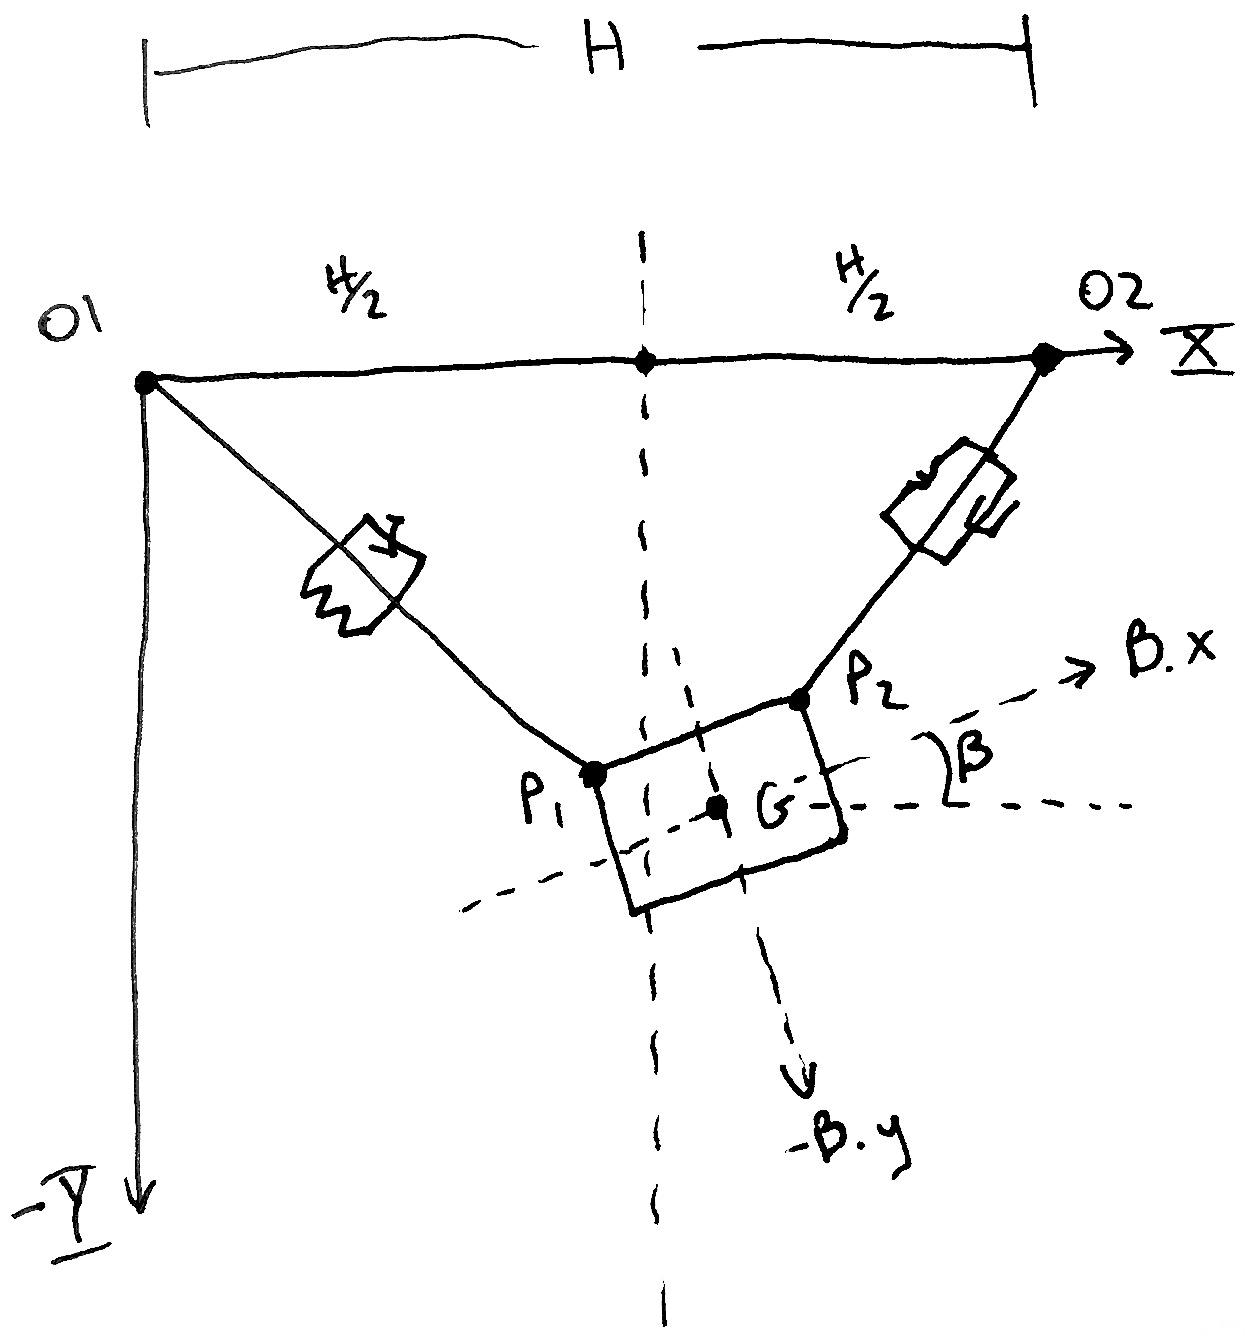

In [2]:
from IPython.display import Image
Image(filename="CDPM.png", embed=True)

## The Problem

We need to find the inital spring lengths so that when the simulation is run the plate does
not move and is in static equilibirum.

* The spring forces are set up like this $$F=k(L_g-L_{init})$$
* $L_g$ is the geometric length resulting from the x and y position of the plate
* We assume the inital lengths will always be shorter than the actual geometric lengths
* Using statics we solved for $L_{init}$ for both the left and right cables.
* When $X=10$ (which means the plate is located along the center line) the formula works
* When the plate is not centered, however, the formula does not work and the plate does not stay in equilibrium
* I removed the rod from the plate to speed up the solver

In [18]:
# Constants
plate_width = 4.0
plate_height = 2.0
plate_mass = 12.0

In [19]:
# Create the variables
x, y, beta, e, F, f = me.dynamicsymbols('x, y, beta e F f')

# Create the velocities
x_dot, y_dot, beta_dot, e_dot = me.dynamicsymbols('x, y, beta e', 1)

# Create the constants
m, k, L, g, H, c, D, t, a, b, m_rod, k_rod, c_rod = sympy.symbols('m k L g H c D t a b m_rod k_rod c_rod', positive=True, real=True)
Izz, Izz_rod, k_beta, c_beta = sympy.symbols('Izz Izz_rod k_beta c_beta', positive=True, real=True)
L_1_init, L_2_init = sympy.symbols('L_1_init L_2_init', positive=True, real=True)
'''
m = mass
k = spring k
L = spring equilibrium length
g = gravity
c = spring c
c_beta = rotational c
k_beta = rotational k
D = rod length
Izz = moment of Inertia about the end of a rod
a = plate width
b = plate height
e = distance from rod CoG and plate CoG
F = force applied to the rod allowing it to move.

'''

# Create the world frame
N = me.ReferenceFrame('N')

# Create the plate frame
B = N.orientnew('B', 'axis', [beta, N.z])

# Create the Origin
O1 = me.Point('O_1')

# Set origin velocity to zero
O1.set_vel(N, 0)

# Create the second attachment point
O2 = O1.locatenew('O_2', H * N.x)
O2.set_vel(N, 0)


In [20]:
G = O1.locatenew('G', x * N.x - y * N.y)
G.set_vel(N, x_dot * N.x - y_dot * N.y)

In [21]:
P1 = G.locatenew('P1', -(a/2) * B.x + (b/2) * B.y)
P1.set_vel(B, 0)
P1.v2pt_theory(G, N, B)

d       
──(x(t))
dt       n_x +  d       
-──(y(t))
 dt       n_y +    d        
-b⋅──(β(t)) 
   dt       
────────────
     2       b_x +    d        
-a⋅──(β(t)) 
   dt       
────────────
     2       b_y

In [22]:
P2 = G.locatenew('P2', (a/2) * B.x + (b/2) * B.y)
P2.set_vel(B, 0)
P2.v2pt_theory(G, N, B)

d       
──(x(t))
dt       n_x +  d       
-──(y(t))
 dt       n_y +    d        
-b⋅──(β(t)) 
   dt       
────────────
     2       b_x +   d       
a⋅──(β(t))
  dt      
──────────
    2      b_y

In [23]:
# Create the plate
I_plate = me.inertia(N, 0, 0, Izz)
inertia = (I_plate, G)
plate = me.RigidBody('plate', G, B, m, inertia)

# Create the distance from the winch/pulley point to each attachment point
L1 = O1.pos_from(P1).magnitude()
L2 = O2.pos_from(P2).magnitude()
L1_vector = O1.pos_from(P1).normalize()
L2_vector = O2.pos_from(P2).normalize()

# Create the height from the center of gravity to the datum
h = G.pos_from(O1) & N.y

In [24]:
# Create the rod
# I_rod = me.inertia(B, 0, 0, Izz_rod)
# rod = me.RigidBody('rod', Z_G, B, m_rod, (I_rod, Z_G))

# Create the height from the center of gravity to the datum
# h_rod = Z_G.pos_from(O1) & N.y

#L1_vector.express(N).subs(beta, 0)
# ((c * P1.vel(N) & L1_vector) * L1_vector).subs({(x, 0), (b, 0), (a,0),(beta, 0)})
# ((c * P2.vel(N) & L2_vector) * L2_vector).subs({(x, 0), (b, 0), (a, 0),(beta, 0)})

In [25]:
forceP1 = -(c * P1.vel(N) & L1_vector) * L1_vector
forceP2 = -(c * P2.vel(N) & L2_vector) * L2_vector

# ignore damping
# forceP1 = 0 * N.z
# forceP2 = 0 * N.z

# The forces on the beta frame
# forceB = c_beta * beta_dot * N.z
forceB = 0 * N.z

# The force on the rod opposing gravity
# force_G = -9.81* rod_mass
# force_G = 0

# The force on the rod moving it
# force_F = (F + force_G) * B.y + c_rod * e_dot * B.y

# The equal and opposite force on the plate
# force_P = -F * B.y

#  + F * B.y
plate.potential_energy = (m * g * h + 0.5 * k * (L_1_init - L1)**2 + 0.5 * k *(L_2_init - L2)**2)

# rod.potential_energy = (-m_rod * g * h_rod + 0.5 * k_rod * (e)**2 + 0.5 * k_beta * beta**2)
# rod.potential_energy = (0)

Lag = me.Lagrangian(N, plate)

LM = me.LagrangesMethod(Lag, [x, y, beta], frame=N, forcelist=[(P1, forceP1),
                                                               (P2, forceP2),
                                                               (B, forceB)])
# (P1, forceP1),(P2, forceP2)

EqMotion = LM.form_lagranges_equations()

lrhs = LM.rhs()
inertia = (plate_width**2 + plate_height**2) * (plate_mass/12.0)
# inertia_rod = (rod_mass * rod_length**2) / 12

In [28]:
# Define the states and state vector
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1 w2 w3 w4 w5 w6', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              y : w2(t),
              beta: w3(t),
              x_dot: w4(t), 
              y_dot: w5(t),
              beta_dot: w6(t),
              m : 12,
              g : 9.81,
              k : 100,
#               L_1_init:s_curve(t, L1_begin, L1_end, Rise_time, time_begin),
#               L_2_init:s_curve(t, L2_begin, L2_end, Rise_time, time_begin),
              L_1_init: 11.2540742933393, #13.2868358631236,
              L_2_init: 11.2540742933393, #9.714687238241817,
              H : 20.0,
              c : 0,
              c_beta: 0,
              k_beta: 0,
              k_rod: 250,
              c_rod: 10,
              a : 4,
              b : 2,
              Izz: (a**2 + b**2) * (m/12.0),
              F: 0}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w),
                              lrhs.subs(sub_params),
                              modules = mat2array)


# x0 = [13, -10, 0, 0.0, 0.0, 0.0]
x0 = [10.0, 13.0, 0.0, 0.0, 0.0, 0.0]

# -0.07848

# Positive beta is to the left when facing the structure
sim_time = np.linspace(0.0, 10, 1001)

# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0]).set_integrator('lsoda', max_step=0.001, atol=1e-9, rtol=1e-6)

# define the sample time
dt = sim_time[1] - sim_time[0]

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

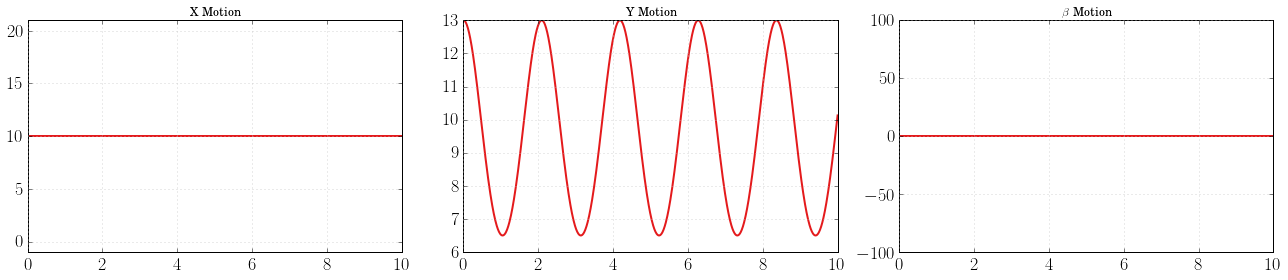

In [29]:
fig = plt.figure(figsize=(18, 4))
fig.add_subplot(131)
plt.plot(sim_time, response[:,0], label='Unshaped')
plt.ylim(-1,21)
plt.title(r'X Motion')

fig.add_subplot(132)
plt.plot(sim_time, response[:,1], label='Unshaped')
# plt.ylim(-30,0)
plt.title(r'Y Motion')

fig.add_subplot(133)
plt.plot(sim_time, np.degrees(response[:,2]), label='Unshaped')
plt.title(r'$\beta$ Motion')
plt.ylim(-100,100)

plt.tight_layout()
# plt.show()